In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Mixture Model using PyStan

## Generate Data Using Numpy

* As you can see the data generated looks like it comes from three gaussians

In [2]:
comp_1 = np.random.normal(3, 1, 500)
comp_2 = np.random.normal(6, 1, 500)
comp_3 = np.random.normal(0, 1, 500)

In [3]:
data = np.concatenate([comp_1, comp_2, comp_3], 0)

In [4]:
data.shape

(1500,)

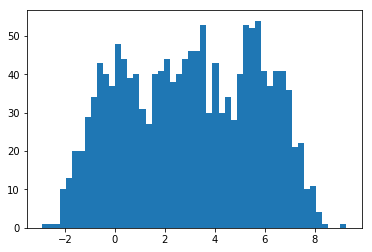

In [5]:
ax = plt.hist(data, bins=50)

## Guess the Data Structure Using PyStan

* Since PyStan does not allow sampling descrete variables, we had to make a workaround.

In [6]:
model_code = """
data {
    int N;        # Number of data points
    int C;        # Number of Componants
    real x[N];    # Data
    vector[C] a;  # Componants' weights' prior param
}
parameters {
    real mus[C];  # Componants' means
    real sigs[C]; # Componants' standard devs
    simplex[C] t; # Each componant's weight
}
model {
    real ps[C];
    
    t ~ dirichlet(a);
    
    for (c in 1:C) {
        mus[c] ~ normal(0, 20);
        sigs[c] ~ inv_gamma(5, 3);
    }
    
    for (n in 1:N) {
        for (c in 1:C) {
            # Here is the workaround. Instead of the following:
            # d <- multinomial(t)
            # x[n] ~ normal(mus[d], sigs[d])
            # We do the following:
            ps[c] = log(t[c]) + normal_log(x[n], mus[c], sigs[c]);
        }
        increment_log_prob(log_sum_exp(ps));
    }
}
"""

In [7]:
mod = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d673f08f7ef7d87d629182d86a2cc828 NOW.


In [8]:
fit = mod.sampling(data={'x': data,
                         'N': len(data),
                         'C': 3,
                         'a': [1, 1, 1]}, iter=1000, chains=4)

/home/nawarhalabi/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


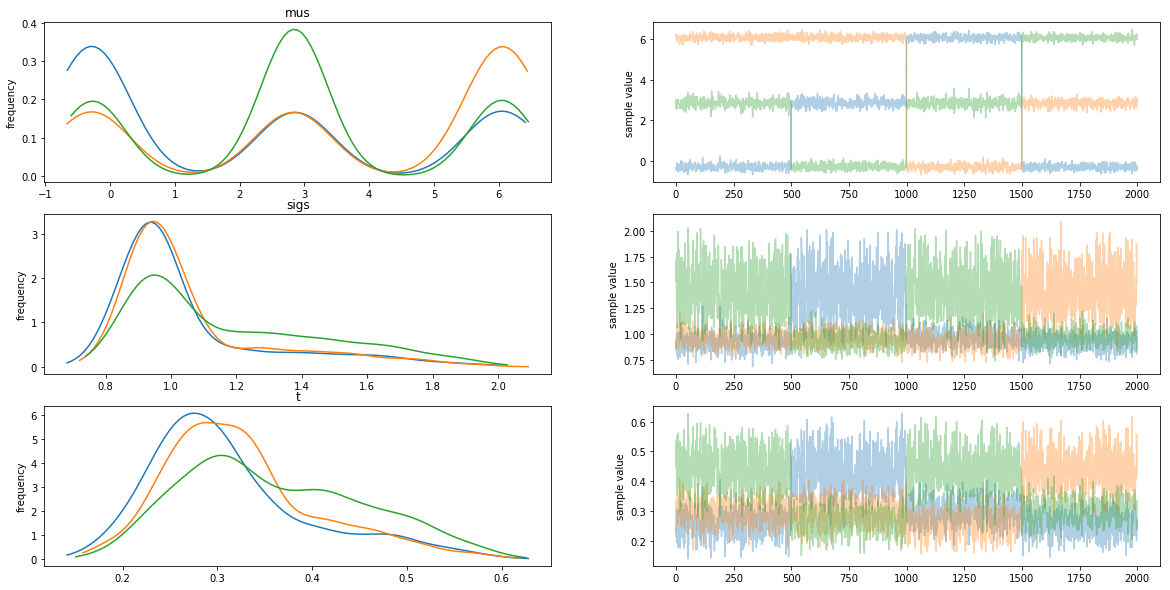

In [9]:
ax = fit.plot()
ax.set_size_inches(20, 10)

# Using Numpy and Hard EM

In [10]:
mus = np.random.normal(0, 20, 3)                     # Mean of each componant
sigs = [1, 1, 1]                                     # Standard Dev of each componant
assignments = np.random.choice([0, 1, 2], 1500, 
                               p=[0.33, 0.33, 0.34]) # Random componant assignment for each datapoint
componants = [0, 1, 2]                               # Componants

In [11]:
def plot_hist_and_means(data, mus):
    """Plot the histogram of data with the mus as red lines"""
    plt.figure()
    plt.hist(data, bins=50)
    for i in mus:
        plt.axvline(i, c='r')
        
    plt.title('mus: {}'.format(mus))

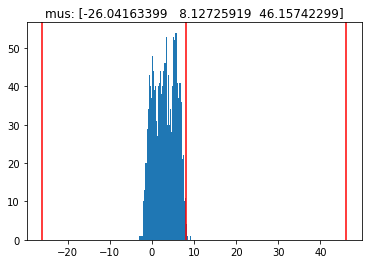

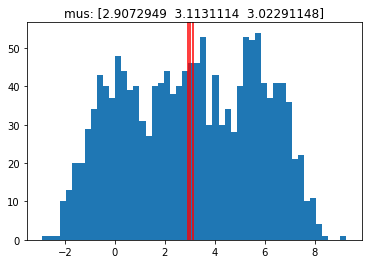

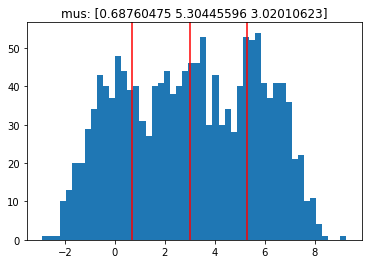

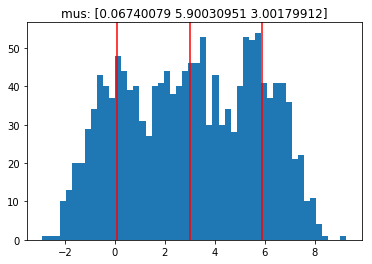

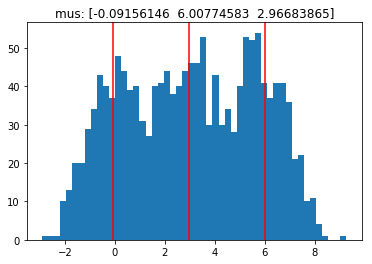

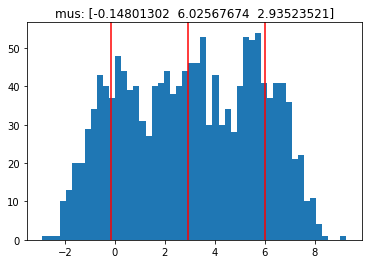

In [12]:
# EM:
# Iterate between:
# 1- getting the new assignment to each point based on its closest componant
# 2- getting the mean of each componat from its assigned points

dif = np.array(np.zeros((len(componants), len(data))))
for i in range(6):
    plot_hist_and_means(data, mus)
    for c in componants:
        mus[c] = data[assignments == c].mean()
        dif[c] = abs(data - mus[c])
    assignments = dif.argmin(axis=0)